In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import openpyxl
from matplotlib import pyplot as plt
import seaborn as sns
import toolbox as tb
import warnings
warnings.filterwarnings("ignore")

In [3]:
## define column names
dtColName = "Datetime"
col_color = "offsetWindDirection"

## define timely aggregation value
timeAgg = ["900S", "720S", "600S", "450S", "300S", "150S",
           "120S", "90S", "60S", "30S", "20S", "10S", "5S"]

## define wind speed ranges
ws_vals = [[2.0, 2.5], [2.5, 3.0], [3.0, 3.5], [3.5, 4.0], 
           [4.0, 4.5], [4.5, 5.0], [5.0, 5.5], [5.5, 6.0]]

## define column names of potentially influental features
colNames = ['RotorSpeed', 'GeneratorSpeed', 'GeneratorTemperature',
            'WindSpeed', 'PowerOutput', 'SpeiseSpannung',
            'StatusAnlage', 'MaxWindHeute', 'elWindDirection',
            'offsetWindDirection', 'PitchDeg']

In [4]:
## load data and convert datetime column to data type datetime
df_raw = pd.read_parquet("dump.parquet")
df_raw.reset_index(inplace=True)
df_raw[dtColName] = pd.to_datetime(df_raw[dtColName])

## use only selected columns
selectedCols = ["year", "Datetime", "PowerOutput", "WindSpeed", "offsetWindDirection"]
df_sel = df_raw[selectedCols[1:]]
df_sel = tb.createDtCols(df=df_sel, dtColName=dtColName)

## drop NANs and map values greater 6 to 6 and values smaller 2 as 2
df_sel = df_sel.dropna()
df_sel["WindSpeed"] = np.where(df_sel["WindSpeed"] > 6.0, 6.0, df_sel["WindSpeed"])
df_sel["WindSpeed"] = np.where(df_sel["WindSpeed"] <= 2.0, 2.00000001, df_sel["WindSpeed"])

### Different Time Aggregations: 
##### Offset Wind Direction (mean) vs Wind Speed
Mean values were manually read from plots that were created by running toolbox.py. <br> Values were inserted into excel spreadsheet. <br>
Each column represents the time interval in seconds for data aggregation (mean).

In [14]:
dfx = pd.read_excel("meanValues_windDir.xlsx", index_col="Windspeed_Interval")
dfx

,10S,20S,30S,60S,90S,120S,150S,300S,450S,600S,720S,900S
Windspeed_Interval,,,,,,,,,,,,
"[2.0, 2.5]",-5.07,-4.97,-4.29,-4.20,-4.25,-4.24,-4.20,-3.94,-3.72,-3.67,-3.60,-3.72
"[2.5, 3.0]",-6.13,-7.14,-6.15,-7.15,-6.37,-7.14,-7.35,-7.50,-7.37,-7.27,-7.33,-7.10
"[3.0, 3.5]",-7.64,-7.54,-8.09,-8.26,-8.29,-8.38,-8.24,-7.98,-7.96,-8.21,-8.50,-7.66
"[3.5, 4.0]",-8.50,-8.27,-8.58,-8.42,-8.82,-8.53,-8.62,-8.58,-8.43,-8.55,-8.70,-8.33
"[4.0, 4.5]",-11.02,-11.01,-10.96,-10.98,-10.81,-10.94,-11.24,-11.04,-10.56,-10.76,-11.19,-10.66
"[4.5, 5.0]",-9.85,-10.02,-10.23,-10.53,-10.56,-10.55,-10.67,-10.50,-10.54,-10.65,-10.78,-10.26
"[5.0, 5.5]",-11.26,-11.32,-11.29,-11.29,-11.41,-11.27,-11.21,-11.32,-11.53,-11.62,-11.13,-11.26
"[5.5, 6.0]",-7.24,-7.38,-7.35,-7.63,-7.60,-7.39,-7.71,-7.57,-7.30,-7.42,-7.57,-7.13


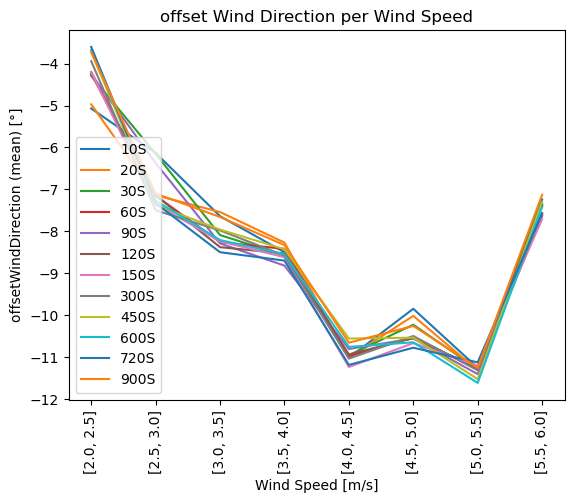

In [15]:
plt.plot(dfx, label=dfx.columns)
plt.xticks(rotation=90)
plt.xlabel("Wind Speed [m/s]")
plt.ylabel("offsetWindDirection (mean) [°]")
plt.title("offset Wind Direction per Wind Speed")
plt.legend(loc='lower left')
plt.show()

##### Power Output (median) vs Wind Speed

Median values were manually read from plots that were created by running toolbox.py. <br> Values were inserted into excel spreadsheet. <br>
Each column represents the time interval in seconds for data aggregation (median).

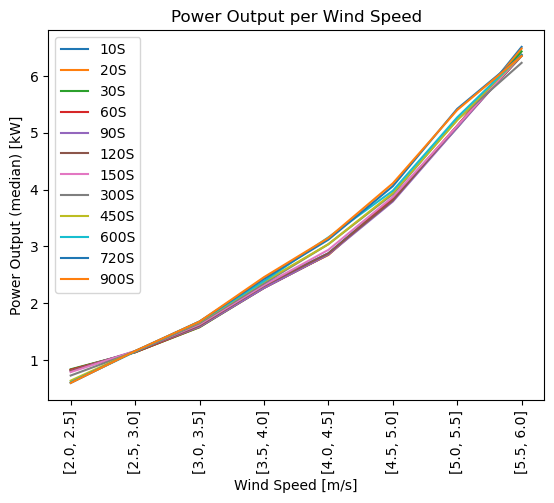

In [16]:
dfx2 = pd.read_excel("medianValues_powerOutput.xlsx", index_col="Windspeed_Interval")

plt.plot(dfx2, label=dfx.columns)
plt.xticks(rotation=90)
plt.xlabel("Wind Speed [m/s]")
plt.ylabel("Power Output (median) [kW]")
plt.title("Power Output per Wind Speed")
plt.legend(loc='upper left')
plt.show()

### Preprocess data
The plot above shows similar behavior for the data which was aggregated (mean) for different time windows. To reduce computational power, a time window of 300s was used for aggregation.

In [5]:
df = tb.preprocessData(df=df_sel,
                       timeAggregation="300S",
                       selectedCols=selectedCols,
                       quant_percent=99.00,
                       cutoff_powerOutput=None
                       )
df.head(3)

,index,PowerOutput,WindSpeed,offsetWindDirection,year,month,weekday,hour,dayOfMonth,dayOfYear,PowerOutputBin,WindSpeedBin,offsetWindDirectionBin
Datetime,,,,,,,,,,,,,
2021-12-31 23:05:00,149.5,0.0,2.0,36.590000,2021.0,12.0,5.0,23.0,31.0,365.0,"(-0.25, 0.0]","(2.0, 2.5]","(35.0, 40.0]"
2021-12-31 23:10:00,449.0,0.0,2.0,12.739130,2021.0,12.0,5.0,23.0,31.0,365.0,"(-0.25, 0.0]","(2.0, 2.5]","(10.0, 15.0]"
2021-12-31 23:15:00,748.5,0.0,2.0,19.173333,2021.0,12.0,5.0,23.0,31.0,365.0,"(-0.25, 0.0]","(2.0, 2.5]","(15.0, 20.0]"


### Correlations
Initial check showed obvious correlations of target variable *PowerOutput* with 
- *WindSpeed* (strong positive)
- *offsetWindDirection* (medium negative)

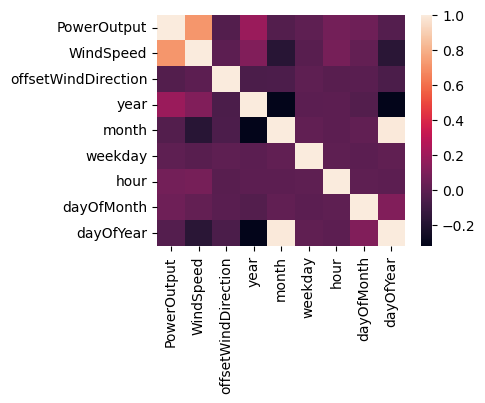

In [6]:
dfs = df.dropna()
dfs.drop(["PowerOutputBin", "WindSpeedBin", "offsetWindDirectionBin"], 
         axis=1, inplace=True)
plt.figure(figsize=(4,3))
sns.heatmap(dfs[dfs.columns[1:]].corr(method="spearman"))
plt.show()

### Distributions

<Figure size 1200x800 with 0 Axes>

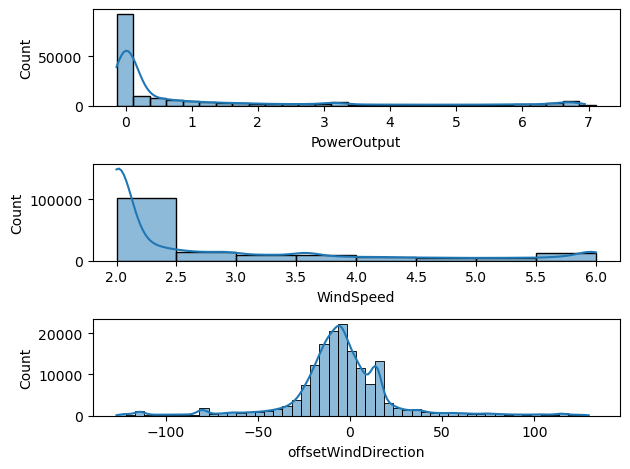

In [7]:
tb.plotHistograms(df, figsize=(12, 8))

### Time Serial Plots

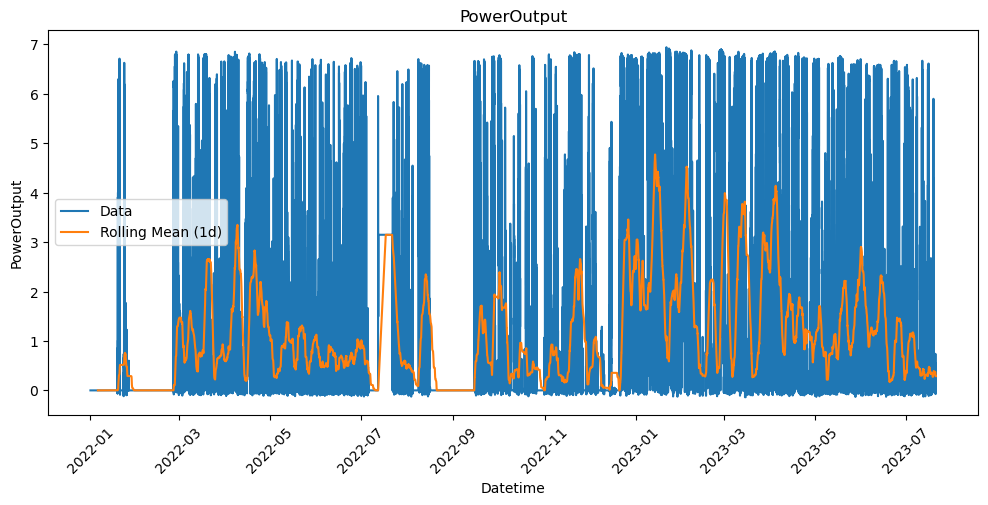

In [8]:
tb.timeSeriesPlot(df=df,
                  y_col="PowerOutput", 
                  rollingMean_days=1)

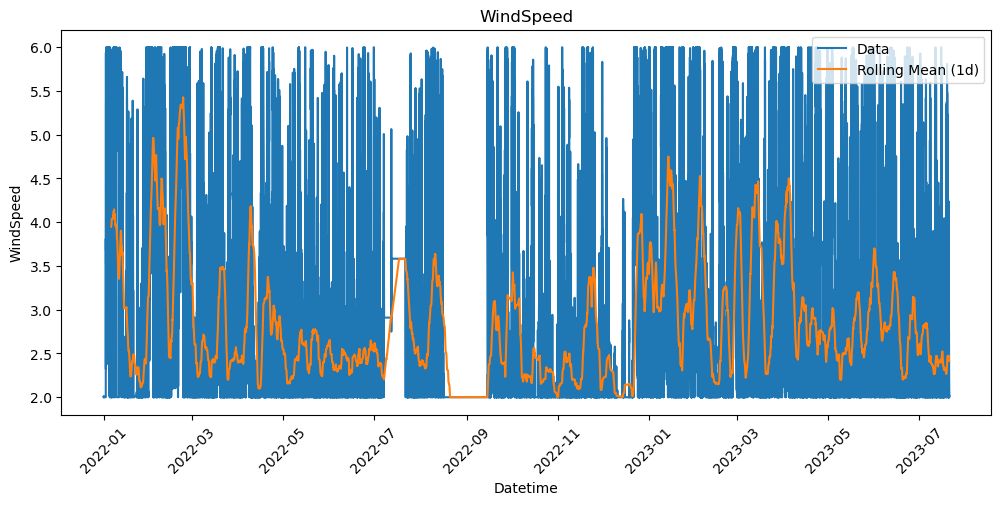

In [9]:
tb.timeSeriesPlot(df=df,
                  y_col="WindSpeed", 
                  rollingMean_days=1)

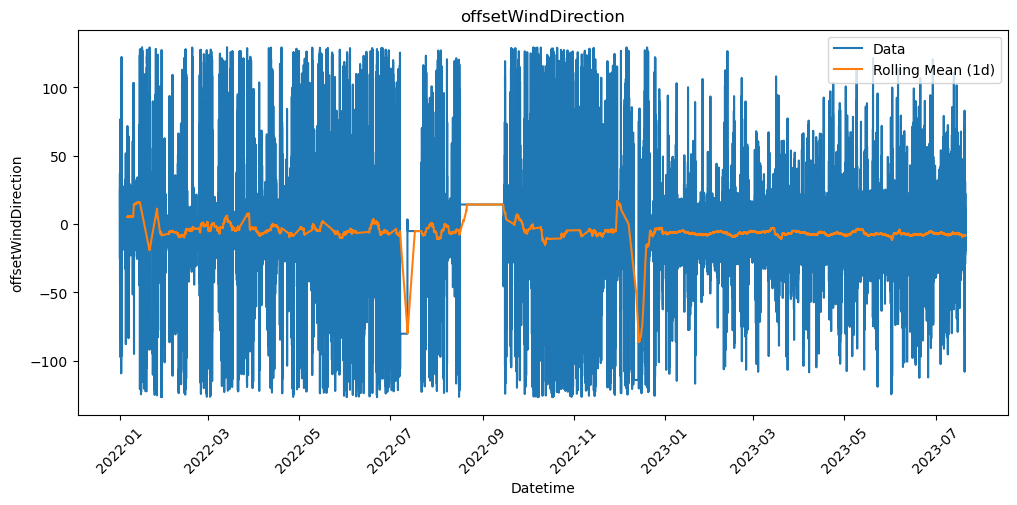

In [10]:
tb.timeSeriesPlot(df=df,
                  y_col="offsetWindDirection", 
                  rollingMean_days=1)

### Time Serial Plots - Differentiated Data
To aim for stationary time series. <br> However, data shows non-constant variance especially for *offsetWindDirection*.

In [11]:
## differentiate data
df["PowerOutput_diff"] = df["PowerOutput"].diff()
df["WindSpeed_diff"] = df["WindSpeed"].diff()
df["offsetWindDirection_diff"] = df["offsetWindDirection"].diff()

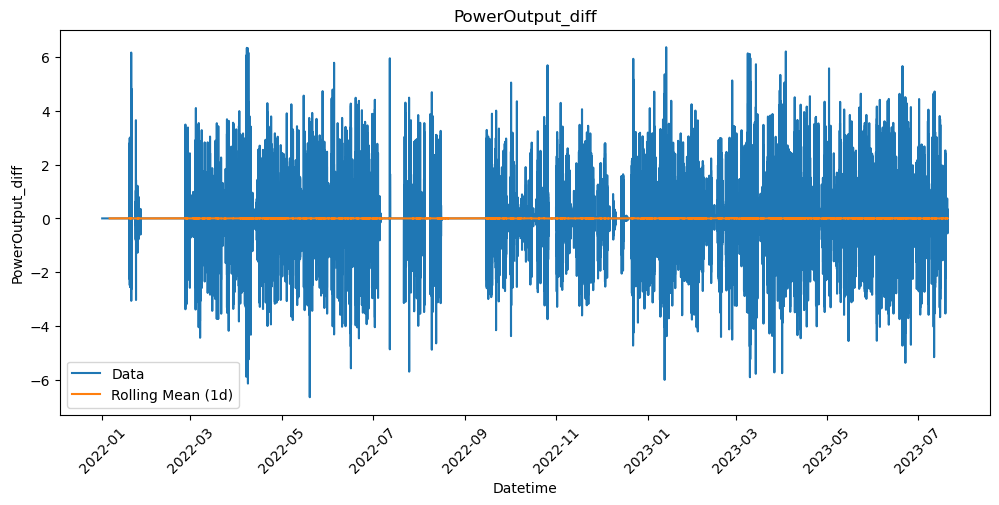

In [12]:
tb.timeSeriesPlot(df=df,
                  y_col="PowerOutput_diff", 
                  rollingMean_days=1)

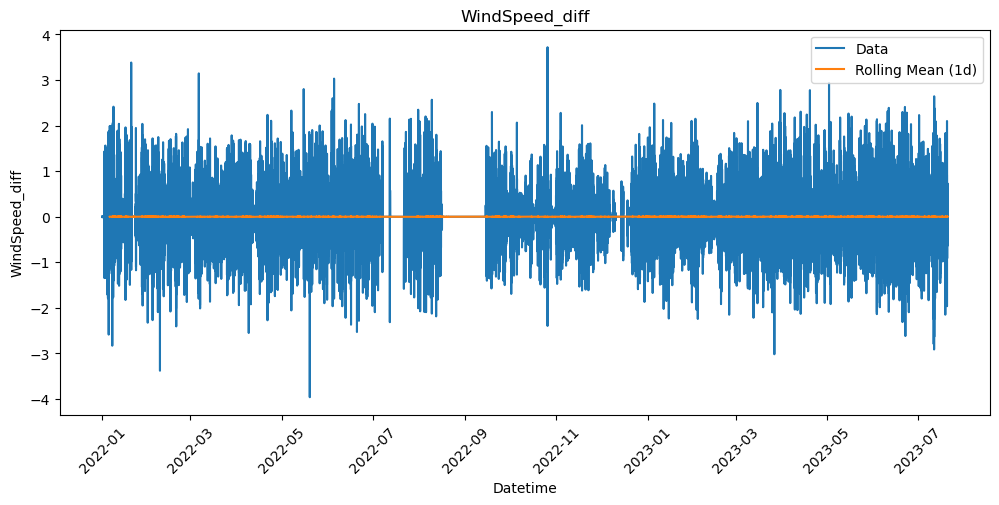

In [13]:
tb.timeSeriesPlot(df=df,
                  y_col="WindSpeed_diff", 
                  rollingMean_days=1)

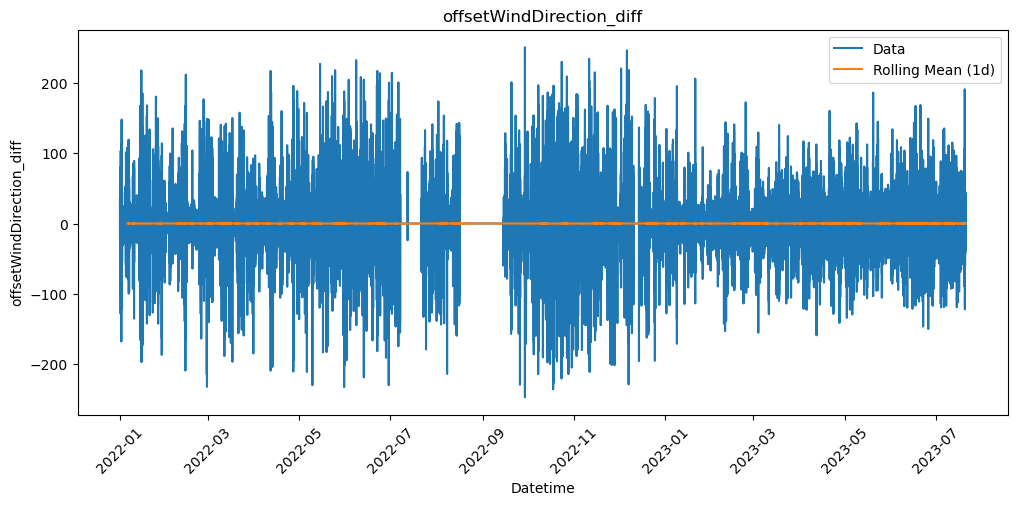

In [14]:
tb.timeSeriesPlot(df=df,
                  y_col="offsetWindDirection_diff", 
                  rollingMean_days=1)

### Check on *PowerOutput* in dependence of *WindSpeed* and *offsetWindDirection*
Extract data between *offsetWindDirection* -30 and +30 degrees for further analyses.

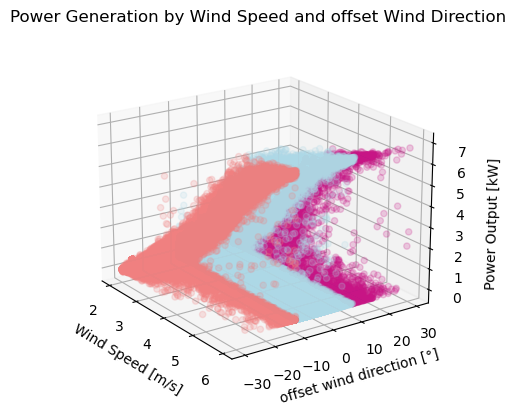

In [15]:
df_cond = df.loc[((df["offsetWindDirection"] > -30.0) & (df["offsetWindDirection"] <= 30.0)), :]
df_cond["color"] = df["offsetWindDirection"].apply(lambda x: "lightcoral" if (x > -30.0) & (x <= -10.0)
                                                        else ("lightblue" if (x > -10.0) & (x <= 10.0)
                                                              else "mediumvioletred") 
                                                  )

xs = df_cond["WindSpeed"]
ys = df_cond["offsetWindDirection"]
zs = df_cond["PowerOutput"]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color=df_cond["color"], alpha=0.2)

ax.set_xlabel("Wind Speed [m/s]")
ax.set_ylabel("offset wind direction [°]")
ax.set_zlabel("Power Output [kW]")
ax.set_title("Power Generation by Wind Speed and offset Wind Direction")

ax.view_init(elev=20., azim=-35, roll=0)
plt.show()

*offsetWindDirection* for higher *WindSpeed* does not seem to be symmetrical aligned around zero. <br>
Therefore create subset for higher *WindSpeed* and higher *PowerOutput*.

##### Check on High PowerOutput and high WindSpeed

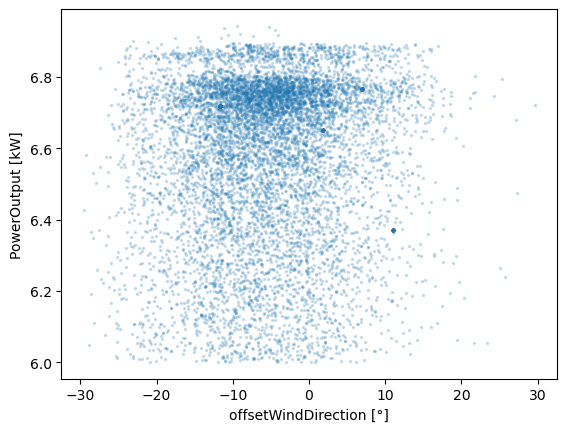

In [16]:
df_cond2 = df_cond.loc[(df_cond["PowerOutput"] > 6) & (df_cond["WindSpeed"] > 5), :]
plt.scatter(df_cond2["offsetWindDirection"], df_cond2["PowerOutput"], alpha=0.2, s=2)
plt.xlabel("offsetWindDirection [°]")
plt.ylabel("PowerOutput [kW]")
plt.show()

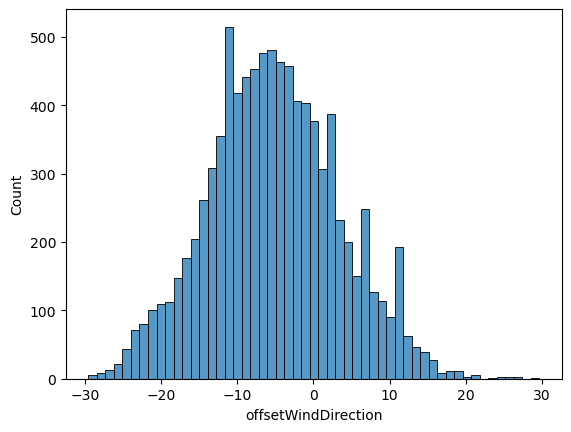

In [17]:
sns.histplot(df_cond2["offsetWindDirection"])
plt.show()

In [18]:
df_cond2["offsetWindDirection"].median()

-5.427380156075808

##### Check on low PowerOutput and low WindSpeed

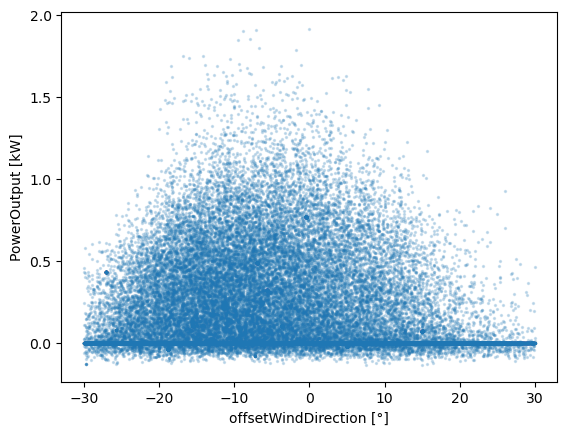

In [19]:
df_cond2 = df_cond.loc[(df_cond["PowerOutput"] <= 2) & (df_cond["WindSpeed"] < 2.5), :]
plt.scatter(df_cond2["offsetWindDirection"], df_cond2["PowerOutput"], alpha=0.2, s=2)
plt.xlabel("offsetWindDirection [°]")
plt.ylabel("PowerOutput [kW]")
plt.show()

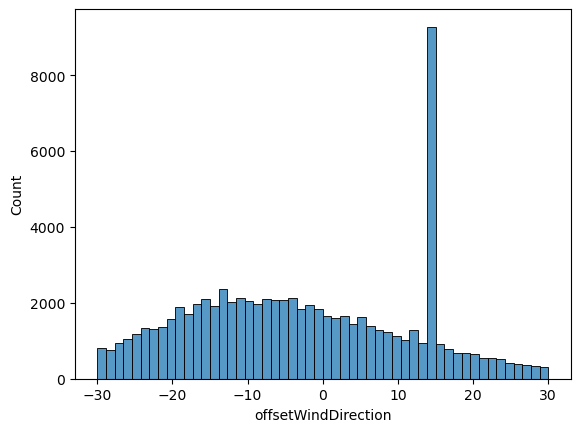

In [20]:
sns.histplot(df_cond2["offsetWindDirection"])
plt.show()

In [21]:
df_cond2["offsetWindDirection"].median()

-3.588477366255144

##### Check on low PowerOutput and high WindSpeed

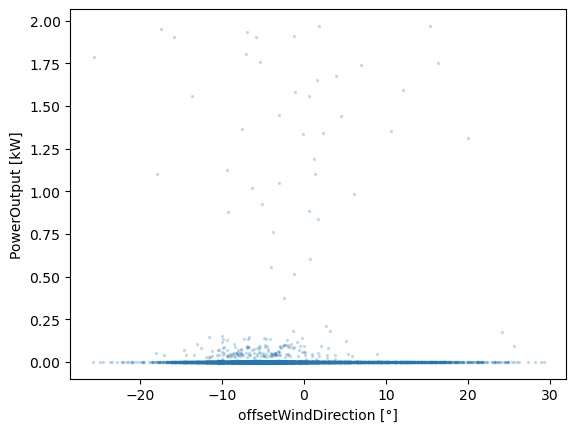

In [22]:
df_cond2 = df_cond.loc[(df_cond["PowerOutput"] < 2) & (df_cond["WindSpeed"] > 5), :]
plt.scatter(df_cond2["offsetWindDirection"], df_cond2["PowerOutput"], alpha=0.2, s=2)
plt.xlabel("offsetWindDirection [°]")
plt.ylabel("PowerOutput [kW]")
plt.show()

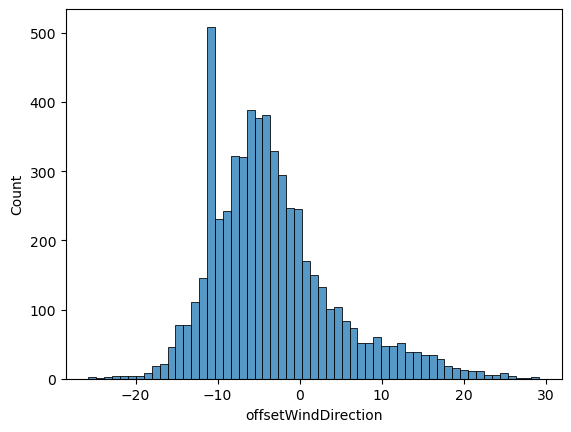

In [23]:
sns.histplot(df_cond2["offsetWindDirection"])
plt.show()

In [24]:
df_cond2["offsetWindDirection"].median()

-4.565217391304348

### Different *offsetWindDirections*: *PowerOutput* vs *WindSpeed*

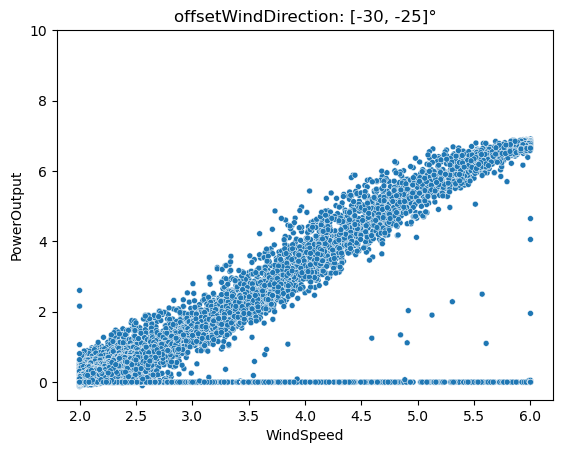

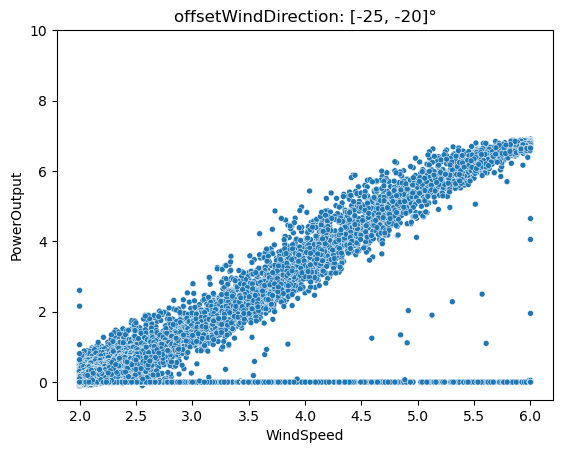

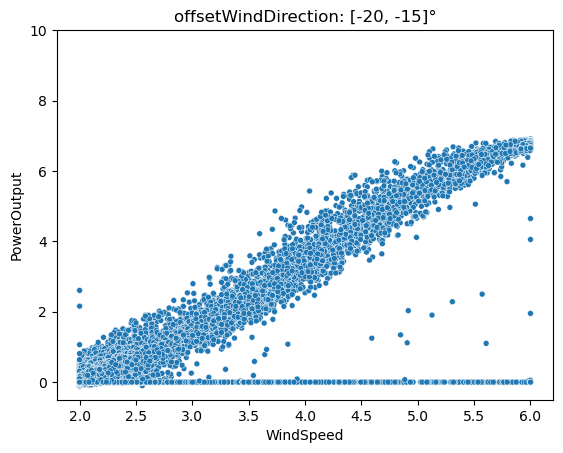

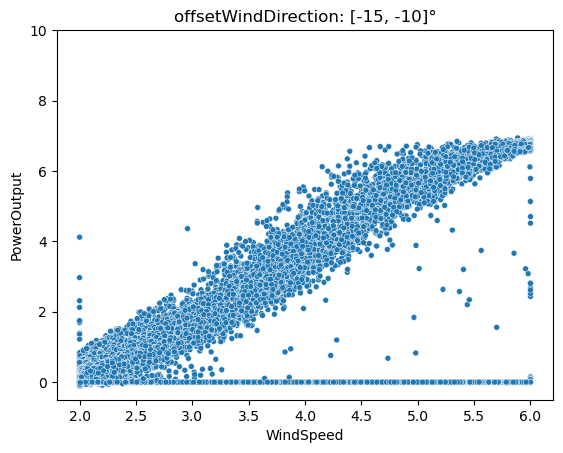

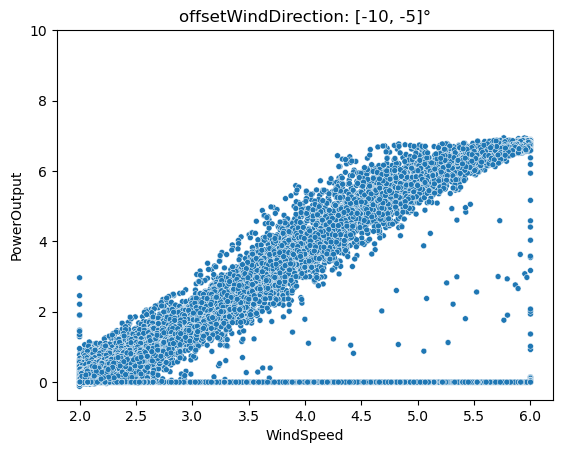

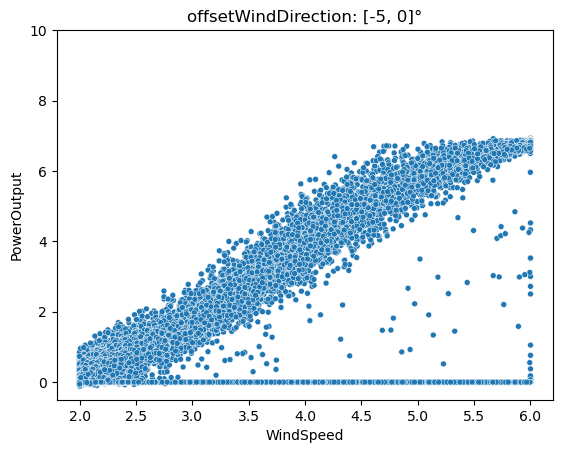

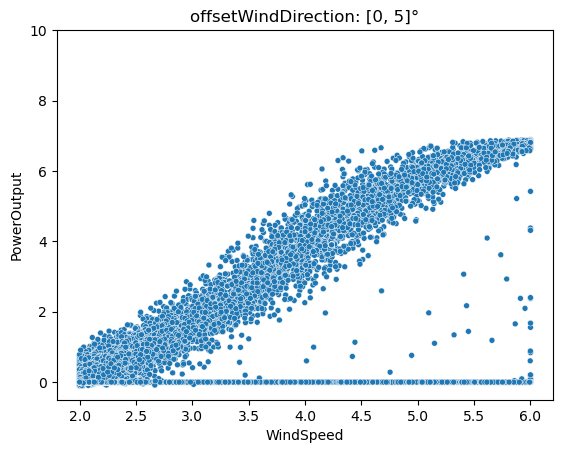

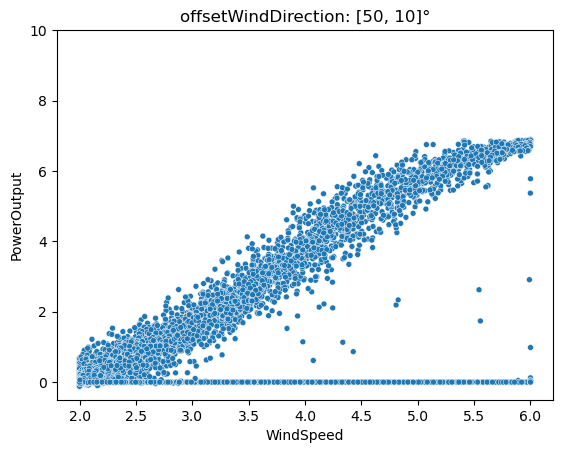

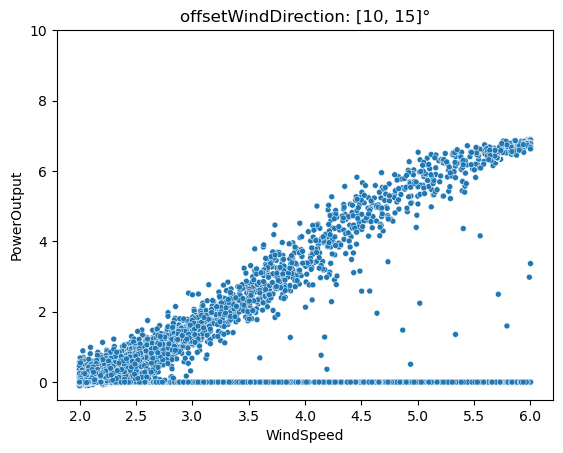

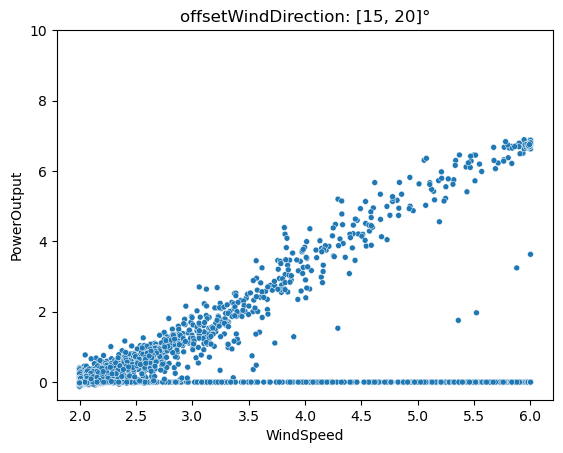

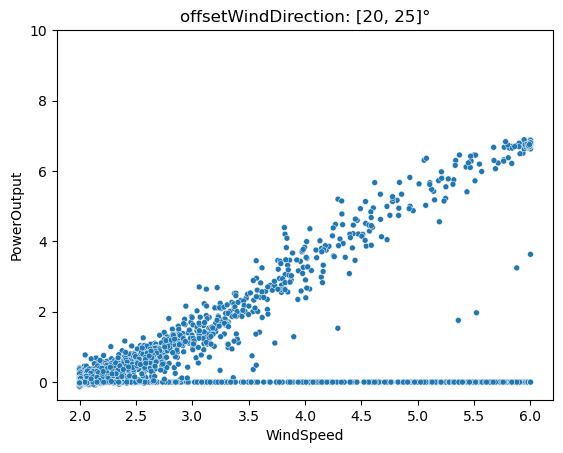

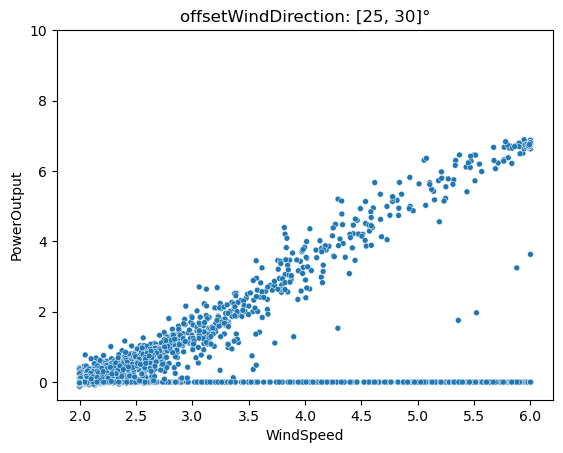

In [25]:
dict_conditions = {"[-30, -25]": ((df["offsetWindDirection"] > -20.0) & (df["offsetWindDirection"] <= -15.0)),
                   "[-25, -20]": ((df["offsetWindDirection"] > -20.0) & (df["offsetWindDirection"] <= -15.0)),
                    "[-20, -15]": ((df["offsetWindDirection"] > -20.0) & (df["offsetWindDirection"] <= -15.0)),
                    "[-15, -10]": ((df["offsetWindDirection"] > -15.0) & (df["offsetWindDirection"] <= -10.0)),
                    "[-10, -5]": ((df["offsetWindDirection"] > -10.0) & (df["offsetWindDirection"] <= -5.0)),
                    "[-5, 0]": ((df["offsetWindDirection"] > -5.0) & (df["offsetWindDirection"] <= 0.0)),
                    "[0, 5]": ((df["offsetWindDirection"] > 0.0) & (df["offsetWindDirection"] <= 5.0)),
                    "[50, 10]": ((df["offsetWindDirection"] > 5.0) & (df["offsetWindDirection"] <= 10.0)),
                    "[10, 15]": ((df["offsetWindDirection"] > 10.0) & (df["offsetWindDirection"] <= 15.0)),
                    "[15, 20]": ((df["offsetWindDirection"] > 15.0) & (df["offsetWindDirection"] <= 20.0)),
                    "[20, 25]": ((df["offsetWindDirection"] > 15.0) & (df["offsetWindDirection"] <= 20.0)),
                    "[25, 30]": ((df["offsetWindDirection"] > 15.0) & (df["offsetWindDirection"] <= 20.0))}

for k, v in dict_conditions.items():
    df_subset = df.loc[v, :]
    sns.scatterplot(data=df_subset, x="WindSpeed", y="PowerOutput", size=2, legend=False)
    plt.title(f"offsetWindDirection: {k}°")
    plt.ylim(-0.5, 10)
    plt.show()

### Evaluate where offsetWindDirection is almost zero

In [26]:
dict_intervals = {}
df2 = df.loc[(df["offsetWindDirection"] >= -5) & (df["offsetWindDirection"] <= 5), :]   
    
for interval in ws_vals: 
    df3 = df2.loc[(df2["WindSpeed"] > interval[0]) & (df2["WindSpeed"] <= interval[1]), :]
    dict_intervals[str(interval)] = {"minimum": '{:.2f}'.format(df3["PowerOutput"].min()),
                                     "maximum": '{:.2f}'.format(df3["PowerOutput"].max()),
                                     "median": '{:.2f}'.format(df3["PowerOutput"].median())
                                    }
dict_intervals

{'[2.0, 2.5]': {'minimum': '-0.12', 'maximum': '1.91', 'median': '0.00'},
 '[2.5, 3.0]': {'minimum': '-0.08', 'maximum': '2.85', 'median': '1.16'},
 '[3.0, 3.5]': {'minimum': '-0.06', 'maximum': '4.15', 'median': '2.09'},
 '[3.5, 4.0]': {'minimum': '0.00', 'maximum': '5.63', 'median': '3.08'},
 '[4.0, 4.5]': {'minimum': '0.00', 'maximum': '6.41', 'median': '4.04'},
 '[4.5, 5.0]': {'minimum': '0.00', 'maximum': '6.71', 'median': '5.22'},
 '[5.0, 5.5]': {'minimum': '0.00', 'maximum': '6.85', 'median': '5.97'},
 '[5.5, 6.0]': {'minimum': '0.00', 'maximum': '6.93', 'median': '6.49'}}

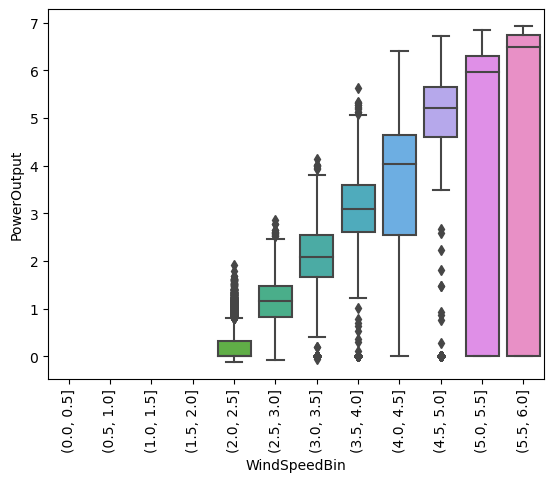

In [27]:
df8 = df2.loc[(df2["WindSpeed"] > 2.0), :]
sns.boxplot(data=df8, x="WindSpeedBin", y="PowerOutput")
plt.xticks(rotation=90)
plt.show()

#### Compare to data of all *offsetWindDirections*

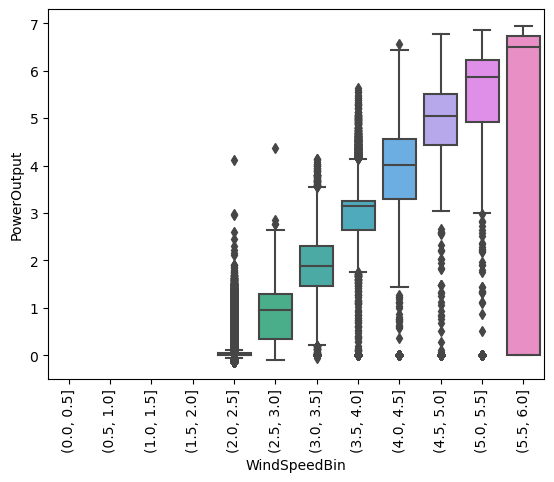

In [28]:
df4 = df.loc[(df["WindSpeed"] > 2.0), :]
sns.boxplot(data=df4, x="WindSpeedBin", y="PowerOutput")
plt.xticks(rotation=90)
plt.show()

##### Check on all available *WindSpeeds* to get a better overview

In [29]:
## load data and convert datetime column to data type datetime
df_raw = pd.read_parquet("dump.parquet")
df_raw.reset_index(inplace=True)
df_raw[dtColName] = pd.to_datetime(df_raw[dtColName])

## use only selected columns
selectedCols = ["year", "Datetime", "PowerOutput", "WindSpeed", "offsetWindDirection"]
df_sel = df_raw[selectedCols[1:]]
df_sel = tb.createDtCols(df=df_sel, dtColName=dtColName)

## drop NANs and map values greater 15 to 15
df_sel2 = df_sel.dropna()
df_sel2["WindSpeed"] = np.where(df_sel2["WindSpeed"] > 15.0, 15.0, df_sel2["WindSpeed"])

df2 = tb.preprocessData(df=df_sel2,
                       timeAggregation="300S",
                       selectedCols=selectedCols,
                       quant_percent=99.00
                       )
df2.head(3)

,index,PowerOutput,WindSpeed,offsetWindDirection,year,month,weekday,hour,dayOfMonth,dayOfYear,PowerOutputBin,WindSpeedBin,offsetWindDirectionBin
Datetime,,,,,,,,,,,,,
2021-12-31 23:05:00,149.5,0.0,0.0300,36.590000,2021.0,12.0,5.0,23.0,31.0,365.0,"(-0.25, 0.0]","(0.0, 0.5]","(35.0, 40.0]"
2021-12-31 23:10:00,449.0,0.0,0.0301,12.739130,2021.0,12.0,5.0,23.0,31.0,365.0,"(-0.25, 0.0]","(0.0, 0.5]","(10.0, 15.0]"
2021-12-31 23:15:00,748.5,0.0,0.0000,19.173333,2021.0,12.0,5.0,23.0,31.0,365.0,"(-0.25, 0.0]",NaN,"(15.0, 20.0]"


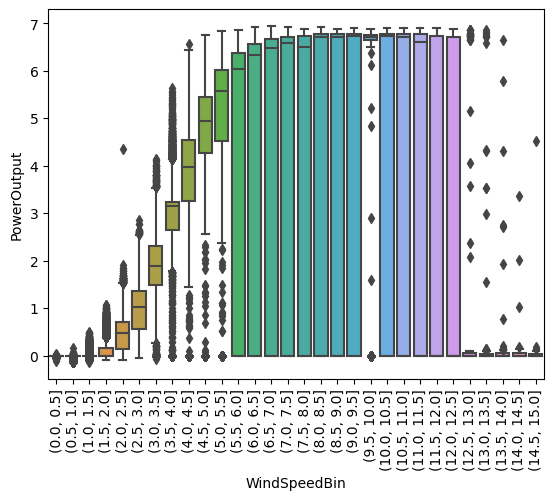

In [30]:
sns.boxplot(data=df2, x="WindSpeedBin", y="PowerOutput")
plt.xticks(rotation=90)
plt.show()

#### Check *PowerOutput* for each *offsetWindDirection*

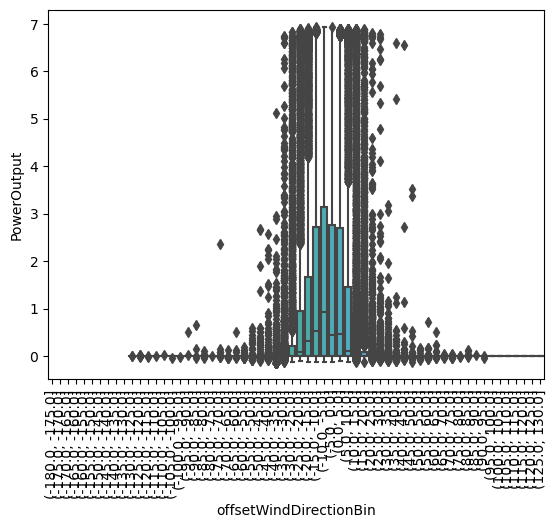

In [31]:
sns.boxplot(data=df, x="offsetWindDirectionBin", y="PowerOutput")
plt.xticks(rotation=90)
plt.show()

Most *PowerOutput* seems to be gained for *offsetWindDirections* between -30 and +30 degrees. <br>
Moreover, about 75% of the power achieved less than 4 kW. 